## Protein Design with Guided Discrete Diffusion

In this tutorial we will demonstrate how to use `cortex` to optimize discrete sequences with the LaMBO-2 algorithm.

In [1]:
# initialize config and wandb
from omegaconf import OmegaConf
import hydra
from cortex.logging import wandb_setup

with hydra.initialize(config_path="./hydra"):
    cfg = hydra.compose(config_name="4_guided_diffusion")
    OmegaConf.set_struct(cfg, False)

wandb_setup(cfg)

/tmp/ipykernel_16857/1122474236.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="./hydra"):
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In '4_guided_diffusion': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: a-crnjar (acrnjar). Use `wandb login --relogin` to force relogin


### Set up initial solution for optimization problem

In this example we will take a green fluorescent protein (GFP) with median fluorescence and optimize it for higher fluorescence.

In [2]:
from cortex.data.dataset import TAPEFluorescenceDataset
# _data_frame_dataset.py  __init__.py  __pycache__  _rfp_dataset.py  _tape_fluorescence.py  _tape_stability.py  _transformed_dataset.py
# /home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/cortex/data/dataset

dataset = TAPEFluorescenceDataset(
    root='./.cache',
    download=True,
    train=True,
)

med_idx = len(dataset) // 2

init_df = dataset._data.sort_values("log_fluorescence").iloc[med_idx : med_idx + 1]
init_df = init_df.sample(n=cfg.optim.max_num_solutions, replace=True)

In [3]:
print(dataset)
print(len(dataset))
#print(dir(dataset))
print(dataset._data.keys())
print(dataset._data['log_fluorescence'])


26808
Index(['primary', 'protein_length', 'log_fluorescence', 'num_mutations', 'id',
       'tokenized_seq'],
      dtype='object')
0        3.823701
1        3.752084
2        3.540156
3        3.691572
4        3.688143
           ...   
26803    3.647678
26804    3.699169
26805    1.435895
26806    3.599729
26807    3.480179
Name: log_fluorescence, Length: 26808, dtype: float64


In [4]:

med_idx = len(dataset) // 2

init_df = dataset._data.sort_values("log_fluorescence").iloc[med_idx : med_idx + 1]
init_df = init_df.sample(n=cfg.optim.max_num_solutions, replace=True)

### Instantiate model

In [5]:
import lightning as L

# set random seed
L.seed_everything(seed=cfg.random_seed, workers=True)

# instantiate model
model = hydra.utils.instantiate(cfg.tree)
model.build_tree(cfg, skip_task_setup=False)

# instantiate trainer, set logger
trainer = hydra.utils.instantiate(cfg.trainer)

Global seed set to 42
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_

using vocab from /home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/cortex/assets/protein_seq_tokenizer_32/vocab.txt
using vocab from /home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/cortex/assets/protein_seq_tokenizer_32/vocab.txt


/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


### (Optional) fit a model to data

If you want to run through this example quickly you can skip this step, in which case the model will be initialized with random parameters.

In [4]:
trainer.fit(
    model,
    train_dataloaders=model.get_dataloader(split="train"),
    val_dataloaders=model.get_dataloader(split="val"),
)

Missing logger folder: /home/alessandro/Documents/GitHub_Local/cortex/tutorials/lightning_logs
2024-06-21 10:41:36.413360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name         | Type       | Params
--------------------------------------------
0 | root_nodes   | ModuleDict | 21.8 K
1 | branch_nodes | ModuleDict | 256   
2 | leaf_nodes   | ModuleDict | 1.1 K 
3 | trunk_node   | SumTrunk   | 0     
--------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.093     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: 0it [00:00, ?it/s]

/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


### Set up guidance objective

We can optimizer for any value function that operates on the activations of the model.
In this example we will use Log Noisy Expected Improvement as the value function.

In [5]:
# construct guidance objective
initial_solution = init_df["tokenized_seq"].values
acq_fn_runtime_kwargs = hydra.utils.call(
    cfg.guidance_objective.runtime_kwargs, model=model, candidate_points=initial_solution
)
acq_fn = hydra.utils.instantiate(cfg.guidance_objective.static_kwargs, **acq_fn_runtime_kwargs)

==== predicting baseline point objective values ====
tensor([[3.2174]])
reference point: tensor([2.8957])


### Set up optimization constraints

Typically we only want to change certain positions in the sequence.
You can specify your own custom constraints by changing `is_mutable`.
In this example `is_mutable` simply excludes utility tokens.

In [6]:
tokenizer_transform = model.root_nodes["protein_seq"].eval_transform
tokenizer = tokenizer_transform[0].tokenizer

tok_idxs = tokenizer_transform(initial_solution)
is_mutable = tokenizer.get_corruptible_mask(tok_idxs)
is_mutable

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

### Score initial solution

Check the initial objective value for comparison later

In [7]:
import torch
with torch.inference_mode():
    tree_output = model.call_from_str_array(initial_solution, corrupt_frac=0.0)
    init_obj_vals = acq_fn.get_objective_vals(tree_output)
    init_acq_vals = acq_fn(tree_output)
print(init_acq_vals)
print(init_obj_vals)

tensor([-14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473,
        -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473,
        -14.0473, -14.0473])
tensor([[[3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174],
         [3.2174]]])


### Run optimization

In [8]:

optimizer = hydra.utils.instantiate(
    cfg.optim,
    params=tok_idxs,
    is_mutable=is_mutable,
    model=model,
    objective=acq_fn,
    constraint_fn=None,
)
for _ in range(cfg.num_steps):
    optimizer.step()
new_designs = optimizer.get_best_solutions()

tensor([-14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473,
        -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473, -14.0473,
        -14.0473, -14.0473])
==== LaMBO-2 Step 1 ====
Optimizing 16 solutions
Selected edit positions: tensor([[165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 174, 175],
        [165, 168, 169, 170, 171, 172, 17

### Score final solution

Let's see how much we improved the objective value (in this example, the acquisition value)!

In [9]:
with torch.inference_mode():
    tree_output = model.call_from_str_array(new_designs["protein_seq"].values, corrupt_frac=0.0)
    final_obj_vals = acq_fn.get_objective_vals(tree_output)
final_obj_vals

tensor([[[3.2174],
         [3.2174],
         [3.2192],
         [3.2207],
         [3.2181],
         [3.2187],
         [3.2182],
         [3.2206],
         [3.2183],
         [3.2174],
         [3.2174],
         [3.2190],
         [3.2188],
         [3.2202],
         [3.2182],
         [3.2195]]])

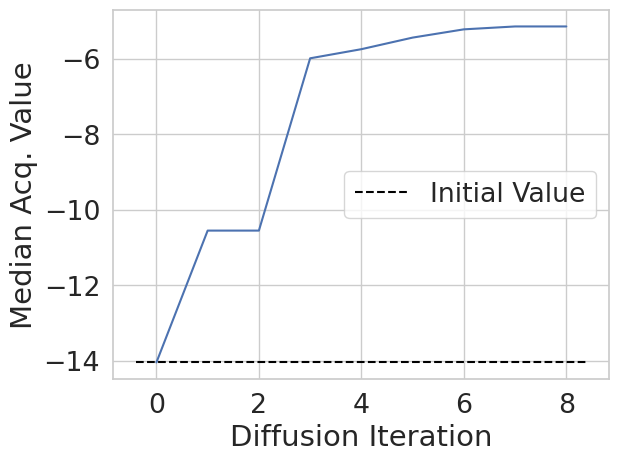

In [10]:
history = optimizer._buffer

med_obj_val = history.groupby("iteration").obj_val.median()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.75)

plt.plot(med_obj_val)
xlim = plt.xlim()
plt.hlines(init_acq_vals.median(), *xlim, label="Initial Value", color="black", linestyle="--")
plt.xlabel("Diffusion Iteration")
plt.ylabel("Median Acq. Value")
plt.legend(loc="center right")

### Visualize the predicted fluorescence of the new sequences

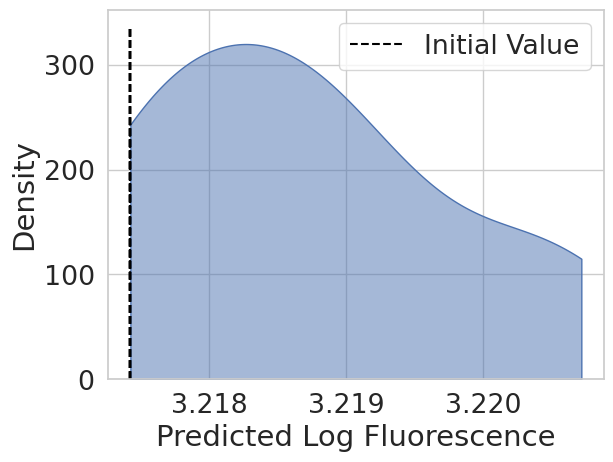

In [11]:
sns.kdeplot(final_obj_vals.view(-1), fill=True, alpha=0.5, cut=0)
ylim = plt.ylim()
plt.vlines(init_obj_vals[0], *ylim, color="black", linestyle="--", label="Initial Value")
plt.xlabel("Predicted Log Fluorescence")
plt.legend()